# Implementing SK-ROCK algorithm - Application to CS-MRI

In this notebook I implement the recently-developed algorithm by Luis Vargas, Marcelo Pereyra and Konstantinos Zygakalis found in [this paper](https://arxiv.org/pdf/1908.08845.pdf).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift
from skimage import data, img_as_float
import helper as t

The image we will be working with for the purposes of this project is the [Shepp Logan phantom](https://en.wikipedia.org/wiki/Shepp%E2%80%93Logan_phantom), and so we load it in the next cell.

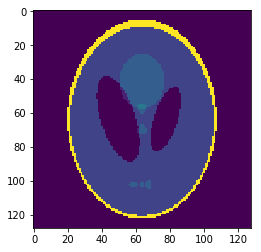

In [2]:
phantom = np.load('phantom.npy')
plt.imshow(phantom)
plt.show()

### The mask

In [3]:
mask_temp = t.LineMask(number_of_angles=36, dim=128)
mask = fftshift(mask_temp)
fourier_op = lambda x: t.masked_FFT(x, mask)
fourier_op_adj = lambda x: np.real(t.masked_FFT_t(x, mask))

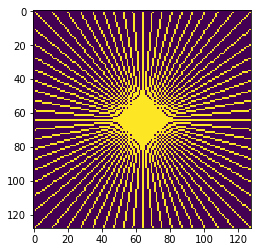

In [4]:
plt.imshow(mask)
plt.show()

### Generation of noisy image (prior)

In [5]:
## generate 'y'
sigma = 1e-3/np.sqrt(2)
transformed_data = fourier_op(phantom)
y = transformed_data + sigma*(np.random.randn(transformed_data.size)+ 
                             1j*np.random.randn(transformed_data.size))

## SK-ROCK Algorithm

The following function generates a given number of samples, given original data, according to the SK-ROCK algorithm

In [6]:
def sk_rock(original_data, num_samples, sigma=1e-3/np.sqrt(2), num_stages=10, eta=0.05 ):
    """
    Generates samples from high-dimensional distributions, according to SK-ROCK 
    algorithm proposed by Luis Vargas et al (2019).
    
    INPUTS:
     - original_data: 
     - image: number of samples to generate
     - sigma:
     - eta: 
     - num_stages: number of internal Runge-Kutta stages
    
    OUTPUTS:
     - the total-variation proximal operator of the image
     
    """
    alpha = 5e-4/sigma**2 # hyperparameter of prior
    lam = 0.2 *sigma**2  #approximation parameter of the MY envelop
    lipschitz_log_likelihood = 1/sigma**2 #Lipschitz constant of the log-likelihood 
    
    
    ## Gradients - proximal gradients and other functions
    def gradF(x):
        return (fourier_op_adj(fourier_op(x) - y))/sigma**2
        
    
    def proxG(x, param=1.25e-20):
        return t.chambolle_prox_TV(phantom, param, 25)
    
    def gradG(x):
        return (x - proxG(x))/lam
    
    def gradU(x):
        return gradF(x) + gradG(x)
    
    def logPi(x):
        return -(np.linalg.norm(y - fourier_op(x))**2)/(2*sigma**2) - alpha*t.TVnorm(x)
    
       
    l = (num_stages - 0.5)**2 * (2 - (4/3)*eta) - 1.5
    step_size = 0.8*l/(lipschitz_log_likelihood + 1/lam)
        
    omega_0 = 1 + eta/num_stages**2
    omega_1 = t.chebyshev(num_stages, omega_0)/t.chebyshev_prime(num_stages, omega_0)
    mu_1 = omega_1/omega_0
    nu_1 = num_stages*omega_1/2
    kappa_1 = num_stages*omega_1/omega_0
    dimension = original_data.shape[0]
    
    
    K = np.ndarray((num_stages, dimension, dimension), dtype=float)
    data = np.ndarray((num_samples, dimension, dimension), dtype=float)
    logPiTraces = np.zeros(num_samples)
    data[0] = original_data
    logPiTraces[0] = logPi(data[0])
    
    for i in range(num_samples-1):
        Z = np.random.randn(dimension, dimension)
        K[0] = data[i]
        K[1] = K[0] - mu_1*step_size*gradU(K[0] + 
                    nu_1*np.sqrt(2*step_size)*Z) + kappa_1*np.sqrt(2*step_size)*Z
        
        for j in range(2,num_stages):
            mu = 2*omega_1*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            nu = 2*omega_0*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            kappa = 1 - nu
            
            K[j] = -mu *step_size*gradU(K[j-1])+ nu*K[j-1]+ kappa*K[j-2]
        data[i+1] = K[num_stages-1]
        logPiTraces[i+1] = logPi(data[i+1])
    return logPiTraces, data

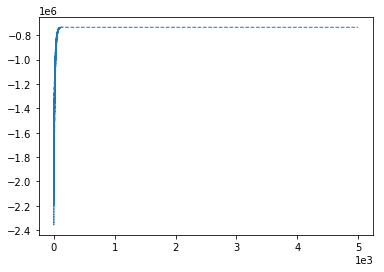

In [7]:
num_samples = 5000 #Generation of samples
logPiTraces, images = sk_rock(fourier_op_adj(y), num_samples)
plt.plot(range(num_samples),logPiTraces, linewidth=1, ls='--')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-24, -7))
plt.show()